In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Standard libraries
import os
import random

# Data processing and visualization
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    UpSampling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Dataset
from tensorflow.keras.datasets import mnist


In [ ]:
# Define paths to the training and testing datasets
train_dir = "/content/drive/MyDrive/DevanagariHandwrittenDigitDataset/Train"
test_dir = "/content/drive/MyDrive/DevanagariHandwrittenDigitDataset/Test"
# Define image dimensions
img_height, img_width = 28, 28

# Function to load grayscale images and labels from a directory structure
def load_images_from_folder(folder_path):
    images = []
    labels = []

    # Get sorted list of class folder names (e.g., digit_0, digit_1, ...)
    class_names = sorted(os.listdir(folder_path))

    # Map class folder names to numeric labels
    class_map = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        label = class_map[class_name]

        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)

            # Load image using PIL, convert to grayscale, resize, and normalize
            img = Image.open(img_path).convert("L")
            img = img.resize((img_width, img_height))
            img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]

            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load training and testing data
train_x, train_y = load_images_from_folder(train_dir)
test_x, test_y = load_images_from_folder(test_dir)


In [ ]:
import numpy as np

def shuffle_data(clean_images, noisy_images_low=None, noisy_images_high=None, random_seed=None):
    """Shuffle clean and optional noisy image datasets with a consistent permutation."""

    if random_seed is not None:
        np.random.seed(random_seed)

    indices = np.random.permutation(len(clean_images))

    shuffled = [arr[indices] if arr is not None else None
                for arr in (clean_images, noisy_images_low, noisy_images_high)]

    return tuple(shuffled)

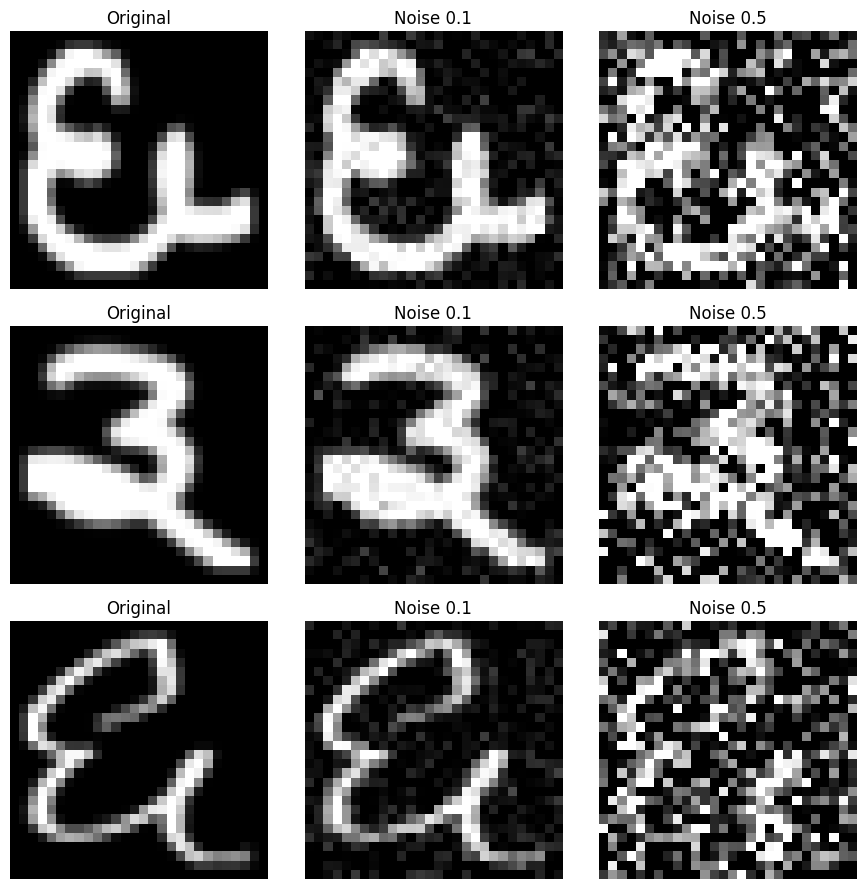

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess MNIST
x_train, x_test = train_x, test_x
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# Generate noisy versions of the data
def add_noise(images, noise_factor):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy, 0., 1.)

x_train_noisy_low = add_noise(x_train, noise_factor=0.1)
x_train_noisy_high = add_noise(x_train, noise_factor=0.5)
x_test_noisy_low = add_noise(x_test, noise_factor=0.1)
x_test_noisy_high = add_noise(x_test, noise_factor=0.5)

# Shuffle data
x_train, x_train_noisy_low, x_train_noisy_high = shuffle_data(
    x_train, x_train_noisy_low, x_train_noisy_high, random_seed=42
)
x_test, x_test_noisy_low, x_test_noisy_high = shuffle_data(
    x_test, x_test_noisy_low, x_test_noisy_high, random_seed=42
)

# Visualize a few samples (original, low noise, high noise)
def visualize_noisy_images(clean, noisy_low, noisy_high, num_images=3):
    plt.figure(figsize=(9, 3 * num_images))
    for i in range(num_images):
        for j, (img, title) in enumerate(zip(
            [clean[i], noisy_low[i], noisy_high[i]],
            ["Original", "Noise 0.1", "Noise 0.5"]
        )):
            ax = plt.subplot(num_images, 3, i * 3 + j + 1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(title)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_noisy_images(x_train, x_train_noisy_low, x_train_noisy_high)


In [ ]:
def build_autoencoder(input_shape=(28, 28, 1)):
    """Builds a simple convolutional autoencoder model."""

    # Encoder
    input_img = Input(shape=input_shape, name="input_layer")
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name="enc_conv1")(input_img)
    x = MaxPooling2D((2, 2), padding='same', name="enc_pool1")(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name="enc_conv2")(x)
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)

    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name="dec_conv1")(encoded)
    x = UpSampling2D((2, 2), name="dec_upsample1")(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name="dec_conv2")(x)
    x = UpSampling2D((2, 2), name="dec_upsample2")(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="output_layer")(x)

    # Autoencoder model
    autoencoder = Model(inputs=input_img, outputs=decoded, name="Autoencoder")
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

In [ ]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv2D)              │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling2D)          │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv1 (Conv2D)              │ (None, 7, 7, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_upsample1 (UpSampling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_conv2 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_upsample2 (UpSampling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Conv2D)           │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build the autoencoder model
autoencoder = build_autoencoder()

# Train the autoencoder using noisy images as input and clean images as target
history = autoencoder.fit(
    x=x_train_noisy_high,
    y=x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy_high, x_test),
    verbose=1  # Optional: controls logging level (0=silent, 1=progress bar, 2=one line per epoch)
)


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.5034 - val_loss: 0.2486
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2404 - val_loss: 0.2228
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2207 - val_loss: 0.2130
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2130 - val_loss: 0.2077
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2076 - val_loss: 0.2038
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2040 - val_loss: 0.2010
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2011 - val_loss: 0.1986
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1989 - val_loss: 0.1971
Epoch 9/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1974 - val_loss: 0.1958
Epoch 10/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1961 - val_loss: 0.1945


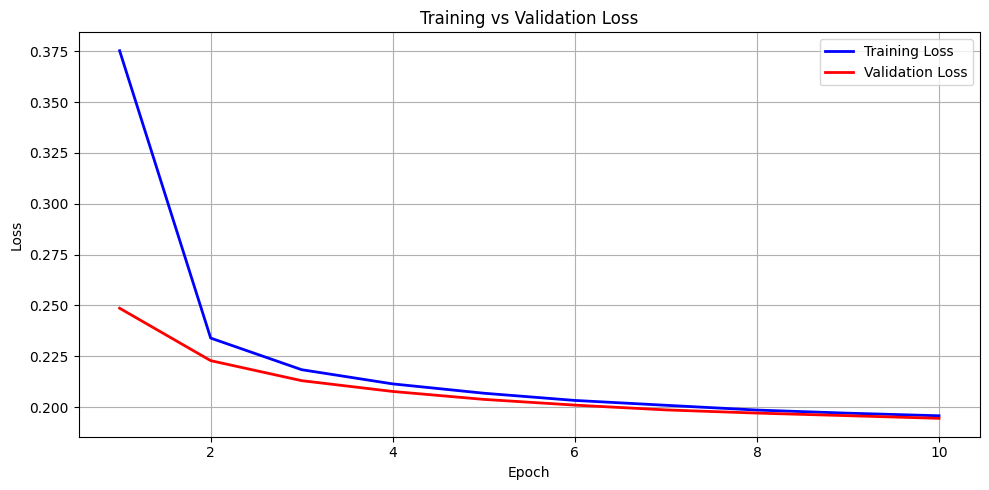

In [ ]:
# Extract loss values from training history
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


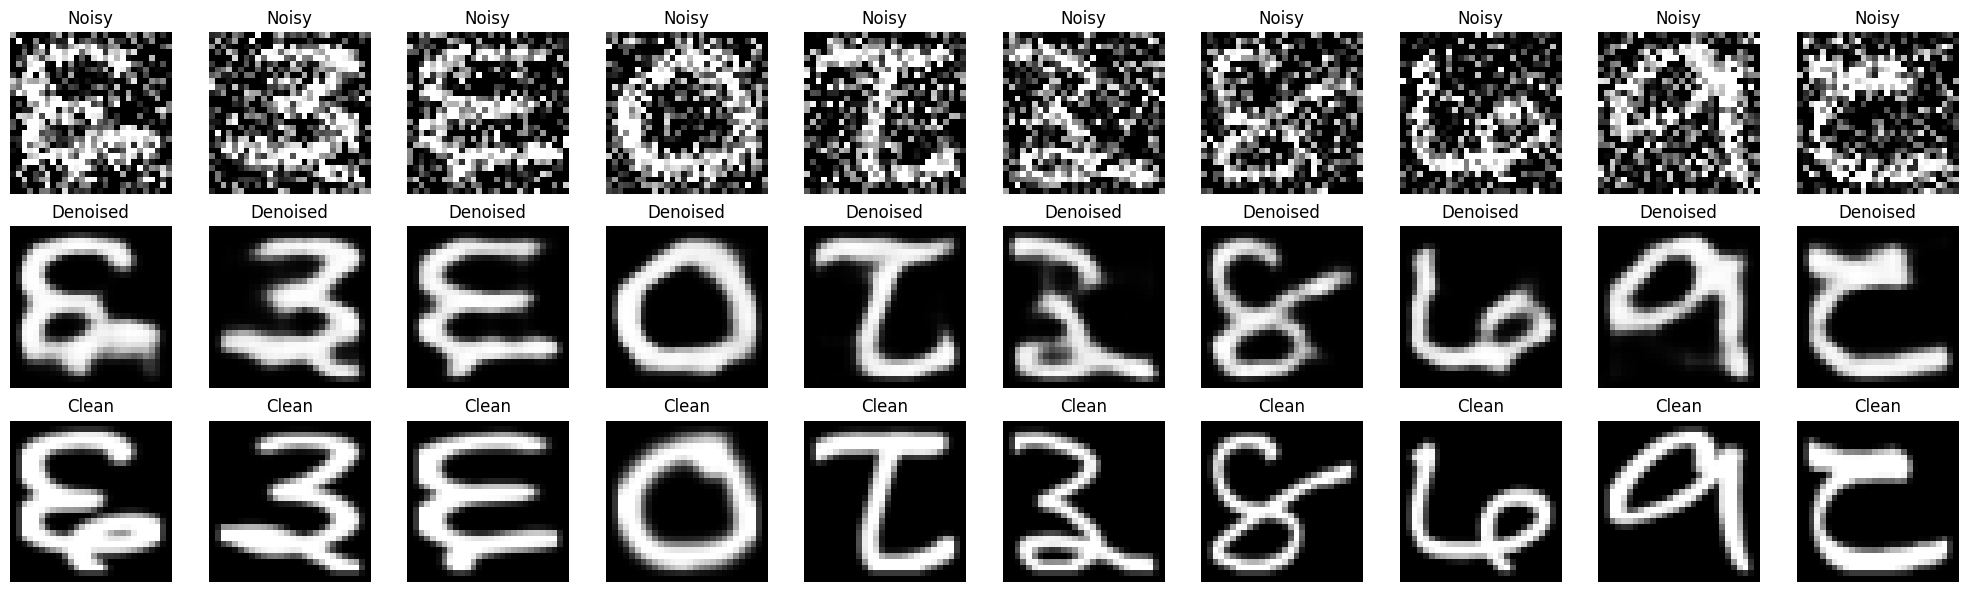

In [ ]:
# Predict denoised images from noisy test inputs
denoised_images = autoencoder.predict(x_test_noisy_high)

# Function to display noisy, denoised, and clean images side by side
def plot_images(noisy, denoised, clean, n=10):
    plt.figure(figsize=(20, 6))

    for i in range(n):
        # Noisy image
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].squeeze(), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised image
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised[i].squeeze(), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Clean image
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean[i].squeeze(), cmap='gray')
        plt.title("Clean")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display a comparison of the first 10 test images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)
